# Urban Sound 10-fold CV

## By Austin Anderson

The purpose of this notebook is to perform 10-fold CV using my favorite models on the author's pre-folded dataset. This file does not contain information regarding audio->spectograms.

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import librosa as lr
import librosa.display
from glob import glob
import IPython.display
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM, Dropout, Dense
from keras.layers import Conv2D, AveragePooling2D
from keras.layers import MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Activation
from keras import regularizers, optimizers
from keras.callbacks import TensorBoard
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import preprocessing
import pickle
import os
from time import time
import seaborn as sns

from keras.applications.resnet50 import ResNet50

Using TensorFlow backend.


## Setting Audio Configurations w/ OneHotEncoding

In [2]:
metadata = pd.read_csv(r"D:\Machine_Learning\UrbanSound8K\UrbanSound8K\metadata\UrbanSound8K.csv")
metadata.set_index('slice_file_name', inplace = True)

# Selects those two columns
classes = metadata[['classID', 'class']]

# Drops duplicates, then sorts by classID
classes = classes.drop_duplicates(subset=['classID','class']).sort_values('classID')

# Make ClassID the index
classes.set_index('classID', inplace = True)

# Print
classes

configs = {}

configs['sampling_rate'] = 22050
configs['duration'] = 4
configs['hop_length'] = 882 # 20ms
configs['fmin'] = 20
configs['fmax'] = configs['sampling_rate'] // 2
configs['n_mels'] = 128
configs['n_fft'] = configs['n_mels'] * 20
configs['samples'] = configs['sampling_rate'] * configs['duration']
configs['dims'] = (configs['n_mels'], 1 + int(np.floor(configs['samples']/configs['hop_length'])), 1)

# Get list of labels in order
my_list = classes["class"].tolist()

# Using sklearn labelencoder
le = preprocessing.LabelEncoder()
le.fit(my_list)

LabelEncoder()

### Saving SKlearn's Confusion Matrix Function (decided not to use in presentation)

In [3]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Displaying first model that I got to work

In [7]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=configs['dims']))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
#model.compile(optimizers.rmsprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 101, 32)      320       
_________________________________________________________________
activation_8 (Activation)    (None, 128, 101, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 126, 99, 64)       18496     
_________________________________________________________________
activation_9 (Activation)    (None, 126, 99, 64)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 49, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 63, 49, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 63, 49, 64)        36928     
__________

## Small Model used in Presentation 

In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=configs['dims']))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))
#model.compile(optimizers.rmsprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 101, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 101, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 128, 101, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 99, 64)       18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 126, 99, 64)       256       
_________________________________________________________________
activation_2 (Activation)    (None, 126, 99, 64)       0         
_________________________________________________________________
max_

### Script to perform 10-fold CV on dataset author's designated folds

In [5]:
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

In [6]:
all_predictions = np.array([])
all_labels = np.array([])

In [7]:
all_predictions = np.array([])
all_labels = np.array([])

# Traverse folders
path = 'D:/Machine_Learning/UrbanSound8K/UrbanSound8K/pickles/'

for folder in os.listdir(path):
    # Look in each folder
    for file in os.listdir(path+"\\"+folder):
        
        file_name = path+"\\"+folder+"\\"+file
        print("TRAINING MODEL ON: "+file_name)

        
        infile = open(file_name,'rb')
        X_train, Y_train, X_test, Y_test = pickle.load(infile)
        infile.close()
        
        model = Sequential()
        model.add(Conv2D(32, (3, 3), padding='same',
                         input_shape=configs['dims']))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(64, (3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv2D(128, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(128, (3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv2D(256, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(256, (3, 3), padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Conv2D(512, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(GlobalAveragePooling2D())
        model.add(Dense(10, activation='softmax'))
        #model.compile(optimizers.rmsprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
        model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])
        
        model.fit(X_train, Y_train,
          batch_size=64,
          epochs=15,
          verbose=1,
          validation_data=(X_test, Y_test))
        
        
        test_predictions = model.predict(X_test)
        clean_predictions = np.argmax(test_predictions,axis=1)
        all_predictions = np.append(all_predictions, clean_predictions)
        
        clean_labels = np.argmax(Y_test,axis=1)
        all_labels = np.append(all_labels, clean_labels)

TRAINING MODEL ON: D:/Machine_Learning/UrbanSound8K/UrbanSound8K/pickles/\10_fold_1\10_fold_1.p
Instructions for updating:
Use tf.cast instead.
Train on 7895 samples, validate on 837 samples
Epoch 1/15
7895/7895 [==============================] - 16s 2ms/step - loss: 1.2466 - acc: 0.5615 - val_loss: 1.8201 - val_acc: 0.4648
Epoch 2/15
7895/7895 [==============================] - 11s 1ms/step - loss: 0.7204 - acc: 0.7478 - val_loss: 1.5051 - val_acc: 0.4970
Epoch 3/15
7895/7895 [==============================] - 12s 1ms/step - loss: 0.4860 - acc: 0.8381 - val_loss: 1.7058 - val_acc: 0.5006
Epoch 4/15
7895/7895 [==============================] - 12s 1ms/step - loss: 0.3632 - acc: 0.8808 - val_loss: 1.2944 - val_acc: 0.6284
Epoch 5/15
7895/7895 [==============================] - 12s 1ms/step - loss: 0.2755 - acc: 0.9099 - val_loss: 1.3859 - val_acc: 0.6559
Epoch 6/15
7895/7895 [==============================] - 12s 1ms/step - loss: 0.2122 - acc: 0.9293 - val_loss: 0.6797 - val_acc: 0.8029

NotADirectoryError: [WinError 267] The directory name is invalid: 'D:/Machine_Learning/UrbanSound8K/UrbanSound8K/pickles/\\resnet_predictions.p'

#### 10-fold CV accuracy

In [12]:
print((0.7157+0.4822+0.7194+0.7246+0.7327+0.7047+0.6923+0.6333+0.6011+0.7365)/10)

0.67425


In [8]:
print(len(all_predictions))
print(len(all_labels))

#Transforming Test matrices
labelled_predictions = le.inverse_transform(all_predictions.astype(int))
labelled_labels = le.inverse_transform(all_labels.astype(int))

8732
8732


In [9]:
confusion = confusion_matrix(labelled_labels, labelled_predictions)
confusion

array([[350,   8,  31,  59, 176, 135,   0,  39,  88, 114],
       [  1, 314,   4,   5,  17,   2,   0,   2,  50,  34],
       [  2,   1, 658, 123,  31,  40,   1,   2,  53,  89],
       [  6,   7,  42, 845,  14,  30,   6,   3,  27,  20],
       [ 47,  22,  18,  28, 729,  26,   4,  73,  19,  34],
       [ 79,   1,  33,  19,  75, 578,   1, 123,  66,  25],
       [  0,   0,   0,  36,  11,   4, 319,   4,   0,   0],
       [ 29,   3,   9,   2, 244,  35,   1, 630,  13,  34],
       [ 14,   4,  91,  47,  62,   8,   1,   1, 658,  43],
       [ 20,   5,  43,  45,  52,  19,   0,   4,  23, 789]], dtype=int64)

Confusion matrix, without normalization
[[350   8  31  59 176 135   0  39  88 114]
 [  1 314   4   5  17   2   0   2  50  34]
 [  2   1 658 123  31  40   1   2  53  89]
 [  6   7  42 845  14  30   6   3  27  20]
 [ 47  22  18  28 729  26   4  73  19  34]
 [ 79   1  33  19  75 578   1 123  66  25]
 [  0   0   0  36  11   4 319   4   0   0]
 [ 29   3   9   2 244  35   1 630  13  34]
 [ 14   4  91  47  62   8   1   1 658  43]
 [ 20   5  43  45  52  19   0   4  23 789]]


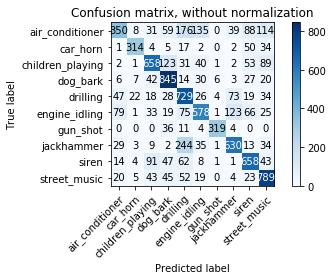

In [10]:
plot_confusion_matrix(labelled_labels, labelled_predictions, classes=my_list,
                      title='Confusion matrix, without normalization')

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text xticklabel objects>)

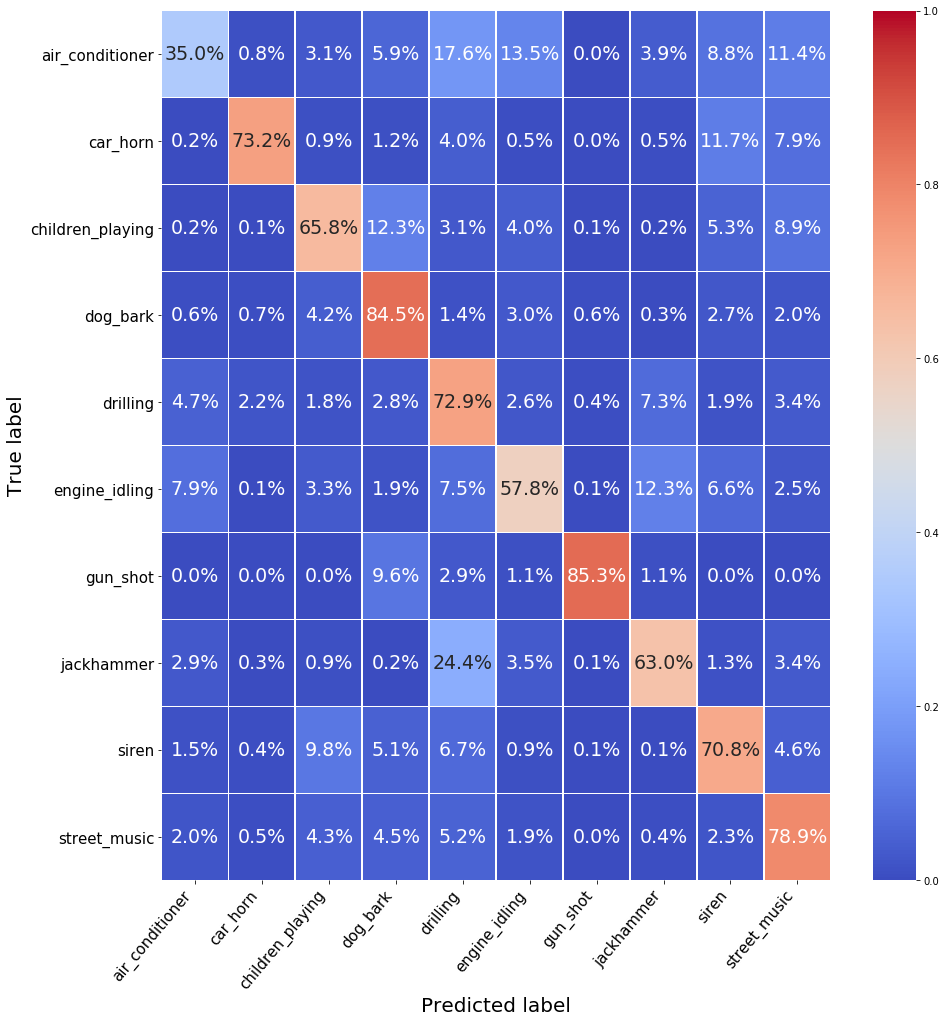

In [11]:
#coolwarm

conf_mat_normalized = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(15,16))
sns.heatmap(conf_mat_normalized,
            annot=True, annot_kws={"size": 19},
                        fmt=".1%",
            xticklabels=my_list,
            yticklabels=my_list,
           vmin=0,
            vmax=1,
            cmap='coolwarm',
           linewidths=.5)
plt.ylabel('True label', size = 20)
plt.xlabel('Predicted label', size = 20)
plt.yticks(rotation=0, size = 15) 
plt.xticks(rotation=50, size = 15, ha='right') 

## Resnet50 10-fold CV

In [85]:
all_predictions = np.array([])
all_labels = np.array([])

# Traverse folders
path = 'D:/Machine_Learning/UrbanSound8K/UrbanSound8K/pickles/'

for folder in os.listdir(path):
    # Look in each folder
    for file in os.listdir(path+"\\"+folder):
        
        file_name = path+"\\"+folder+"\\"+file
        print("TRAINING MODEL ON: "+file_name)

        
        infile = open(file_name,'rb')
        X_train, Y_train, X_test, Y_test = pickle.load(infile)
        infile.close()
        
        X_train_3d = np.squeeze(np.stack((X_train,) * 3, -1))
        X_test_3d = np.squeeze(np.stack((X_test,) * 3, -1))
        
        resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128,101,3))
        x = resnet_model.output
        x = GlobalAveragePooling2D()(x)
        #x = Dropout(0.7)(x)
        predictions = Dense(10, activation= 'softmax')(x)
        final_model = Model(inputs = resnet_model.input, outputs = predictions)
        final_model.compile(optimizers.rmsprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
        
        final_model.fit(X_train_3d, Y_train,
          batch_size=32,
          epochs=20,
          verbose=1,
          validation_data=(X_test_3d, Y_test))
        
        
        test_predictions = final_model.predict(X_test_3d)
        clean_predictions = np.argmax(test_predictions,axis=1)
        all_predictions = np.append(all_predictions, clean_predictions)
        
        clean_labels = np.argmax(Y_test,axis=1)
        all_labels = np.append(all_labels, clean_labels)

TRAINING MODEL ON: D:/Machine_Learning/UrbanSound8K/UrbanSound8K/pickles/\10_fold_1\10_fold_1.p
Train on 7895 samples, validate on 837 samples
Epoch 1/20
7895/7895 [==============================] - 46s 6ms/step - loss: 1.3923 - acc: 0.6821 - val_loss: 6.9452 - val_acc: 0.2736
Epoch 2/20
7895/7895 [==============================] - 28s 4ms/step - loss: 0.6807 - acc: 0.8328 - val_loss: 6.1329 - val_acc: 0.3680
Epoch 3/20
7895/7895 [==============================] - 28s 4ms/step - loss: 0.2895 - acc: 0.9101 - val_loss: 3.0081 - val_acc: 0.6476
Epoch 4/20
7895/7895 [==============================] - 28s 4ms/step - loss: 0.1893 - acc: 0.9403 - val_loss: 1.2177 - val_acc: 0.7443
Epoch 5/20
7895/7895 [==============================] - 28s 4ms/step - loss: 0.1362 - acc: 0.9576 - val_loss: 1.2081 - val_acc: 0.7730
Epoch 6/20
7895/7895 [==============================] - 28s 4ms/step - loss: 0.1142 - acc: 0.9658 - val_loss: 2.1561 - val_acc: 0.6738
Epoch 7/20
7895/7895 [=========================

#### 10-fold CV accuracy

In [88]:
print((0.7467+0.7308+0.7782+0.7122+0.6909+0.6318+0.7991+0.7616+0.6314+0.6858)/10)

0.71685


In [92]:
print(len(all_predictions))
print(len(all_labels))

#Transforming Test matrices
labelled_predictions = le.inverse_transform(all_predictions.astype(int))
labelled_labels = le.inverse_transform(all_labels.astype(int))

8732
8732


In [4]:
#pickle.dump([labelled_predictions, labelled_labels], open('D:/Machine_Learning/UrbanSound8K/UrbanSound8K/pickles/resnet_predictions.p', 'wb'))

infile = open('D:/Machine_Learning/UrbanSound8K/UrbanSound8K/pickles/resnet_predictions.p','rb')
labelled_predictions, labelled_labels = pickle.load(infile)
infile.close()

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text xticklabel objects>)

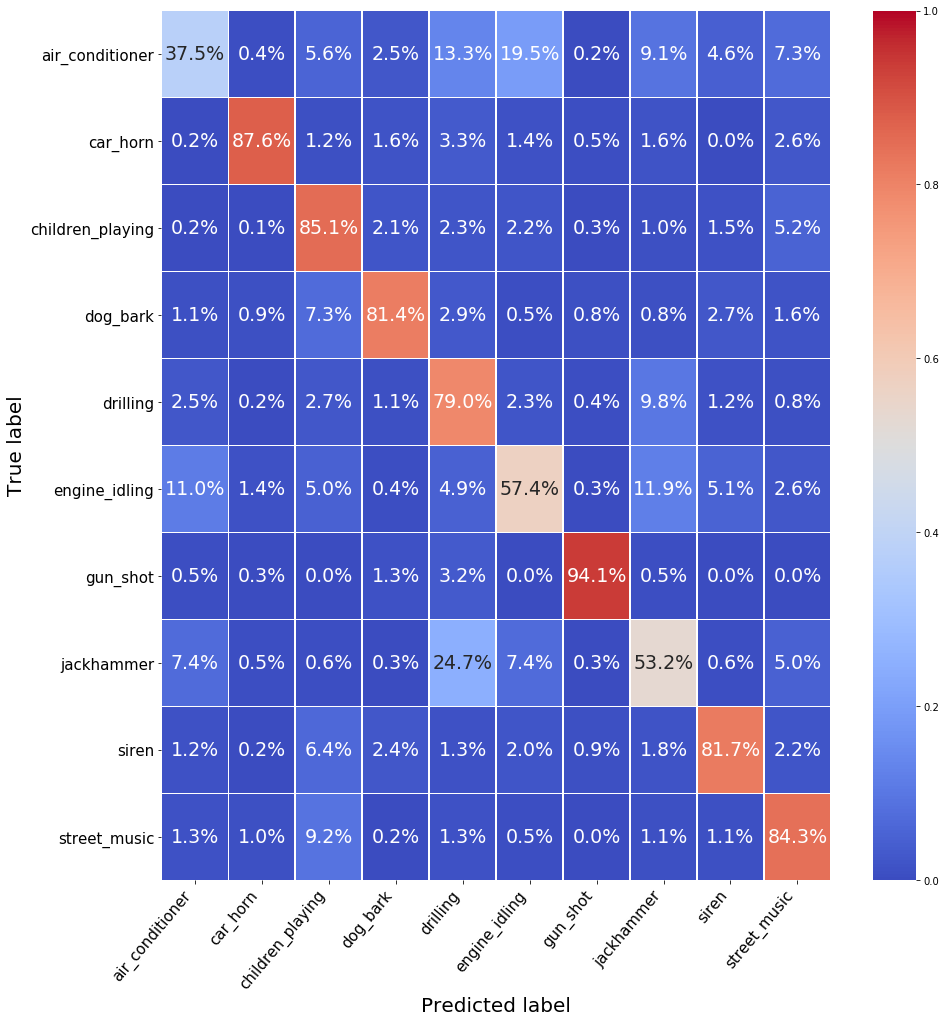

In [8]:
#coolwarm

confusion = confusion_matrix(labelled_labels, labelled_predictions)
confusion

conf_mat_normalized = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(15,16))
sns.heatmap(conf_mat_normalized,
            annot=True, annot_kws={"size": 19},
                        fmt=".1%",
            xticklabels=my_list,
            yticklabels=my_list,
           vmin=0,
            vmax=1,
            cmap='coolwarm',
           linewidths=.5)
plt.ylabel('True label', size = 20)
plt.xlabel('Predicted label', size = 20)
plt.yticks(rotation=0, size = 15) 
plt.xticks(rotation=50, size = 15, ha='right') 



### These lines are just loading in data and trying to get tensorboard to work

In [5]:
infile = open('D:/Machine_Learning/UrbanSound8K/UrbanSound8K/pickles/10_fold_10/10_fold_10.p','rb')
X_train, Y_train, X_test, Y_test = pickle.load(infile)
infile.close()

In [9]:
model.fit(X_train, Y_train,
          batch_size=64,
          epochs=40,
          verbose=1,
          validation_data=(X_test, Y_test),
         callbacks=[tensorboard])

Train on 7859 samples, validate on 873 samples
Epoch 1/40
7859/7859 [==============================] - 8s 1ms/step - loss: 0.0850 - acc: 0.9715 - val_loss: 2.1115 - val_acc: 0.7274
Epoch 2/40
7859/7859 [==============================] - 7s 952us/step - loss: 0.0736 - acc: 0.9766 - val_loss: 2.1306 - val_acc: 0.7365
Epoch 3/40
7859/7859 [==============================] - 7s 953us/step - loss: 0.0635 - acc: 0.9776 - val_loss: 1.9188 - val_acc: 0.7239
Epoch 4/40
7859/7859 [==============================] - 7s 950us/step - loss: 0.0571 - acc: 0.9809 - val_loss: 1.7451 - val_acc: 0.7365
Epoch 5/40
7859/7859 [==============================] - 8s 978us/step - loss: 0.0654 - acc: 0.9785 - val_loss: 1.9561 - val_acc: 0.7148
Epoch 6/40
7859/7859 [==============================] - 8s 977us/step - loss: 0.0689 - acc: 0.9772 - val_loss: 1.9814 - val_acc: 0.7125
Epoch 7/40
7859/7859 [==============================] - 8s 958us/step - loss: 0.0526 - acc: 0.9823 - val_loss: 1.8013 - val_acc: 0.7205
Epo

 Go into D:\Machine_Learning\UrbanSound8K\UrbanSound8K and then use: tensorboard --logdir=logs/ and then open http://localhost:6006/ in browser

## Below this point is a graveyard of some models I didn't overwrite in the optimization process

In [12]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=configs['dims']))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(10, activation='softmax'))
#model.compile(optimizers.rmsprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 128, 101, 32)      320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 101, 32)      128       
_________________________________________________________________
activation_22 (Activation)   (None, 128, 101, 32)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 126, 99, 64)       18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 126, 99, 64)       256       
_________________________________________________________________
activation_23 (Activation)   (None, 126, 99, 64)       0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 63, 49, 64)        0         
__________

In [13]:
model.fit(X_train, Y_train,
          batch_size=64,
          epochs=40,
          verbose=1,
          validation_data=(X_test, Y_test),
         callbacks=[tensorboard])

Train on 7859 samples, validate on 873 samples
Epoch 1/40
7859/7859 [==============================] - 11s 1ms/step - loss: 0.9298 - acc: 0.7014 - val_loss: 1.7834 - val_acc: 0.5120
Epoch 2/40
7859/7859 [==============================] - 10s 1ms/step - loss: 0.3289 - acc: 0.8916 - val_loss: 1.0330 - val_acc: 0.6919
Epoch 3/40
7859/7859 [==============================] - 10s 1ms/step - loss: 0.1556 - acc: 0.9511 - val_loss: 1.2267 - val_acc: 0.6609
Epoch 4/40
7859/7859 [==============================] - 10s 1ms/step - loss: 0.0654 - acc: 0.9827 - val_loss: 2.1240 - val_acc: 0.6208
Epoch 5/40
7859/7859 [==============================] - 10s 1ms/step - loss: 0.0466 - acc: 0.9868 - val_loss: 1.7759 - val_acc: 0.6186
Epoch 6/40
7859/7859 [==============================] - 10s 1ms/step - loss: 0.0214 - acc: 0.9953 - val_loss: 1.3726 - val_acc: 0.6747
Epoch 7/40
7859/7859 [==============================] - 10s 1ms/step - loss: 0.0179 - acc: 0.9955 - val_loss: 1.6027 - val_acc: 0.6678
Epoch 8/

In [14]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=configs['dims']))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
#model.compile(optimizers.rmsprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 128, 101, 32)      320       
_________________________________________________________________
batch_normalization_9 (Batch (None, 128, 101, 32)      128       
_________________________________________________________________
activation_29 (Activation)   (None, 128, 101, 32)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 126, 99, 64)       18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 126, 99, 64)       256       
_________________________________________________________________
activation_30 (Activation)   (None, 126, 99, 64)       0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 63, 49, 64)        0         
__________

In [15]:
model.fit(X_train, Y_train,
          batch_size=64,
          epochs=40,
          verbose=1,
          validation_data=(X_test, Y_test),
         callbacks=[tensorboard])

Train on 7859 samples, validate on 873 samples
Epoch 1/40
7859/7859 [==============================] - 11s 1ms/step - loss: 1.0677 - acc: 0.6505 - val_loss: 1.0418 - val_acc: 0.6403
Epoch 2/40
7859/7859 [==============================] - 10s 1ms/step - loss: 0.4425 - acc: 0.8560 - val_loss: 2.3251 - val_acc: 0.4788
Epoch 3/40
7859/7859 [==============================] - 10s 1ms/step - loss: 0.2520 - acc: 0.9193 - val_loss: 1.6075 - val_acc: 0.6300
Epoch 4/40
7859/7859 [==============================] - 10s 1ms/step - loss: 0.1456 - acc: 0.9523 - val_loss: 1.6494 - val_acc: 0.6804
Epoch 5/40
7859/7859 [==============================] - 10s 1ms/step - loss: 0.0874 - acc: 0.9746 - val_loss: 1.8041 - val_acc: 0.6380
Epoch 6/40
7859/7859 [==============================] - 10s 1ms/step - loss: 0.0553 - acc: 0.9863 - val_loss: 1.5812 - val_acc: 0.6174
Epoch 7/40
7859/7859 [==============================] - 10s 1ms/step - loss: 0.0410 - acc: 0.9893 - val_loss: 1.4793 - val_acc: 0.7068
Epoch 8/

In [17]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=configs['dims']))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
#model.compile(optimizers.rmsprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_37 (Conv2D)           (None, 128, 101, 32)      320       
_________________________________________________________________
batch_normalization_23 (Batc (None, 128, 101, 32)      128       
_________________________________________________________________
activation_43 (Activation)   (None, 128, 101, 32)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 126, 99, 64)       18496     
_________________________________________________________________
batch_normalization_24 (Batc (None, 126, 99, 64)       256       
_________________________________________________________________
activation_44 (Activation)   (None, 126, 99, 64)       0         
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 63, 49, 64)        0         
__________

In [18]:
model.fit(X_train, Y_train,
          batch_size=64,
          epochs=40,
          verbose=1,
          validation_data=(X_test, Y_test),
         callbacks=[tensorboard])

Train on 7859 samples, validate on 873 samples
Epoch 1/40
7859/7859 [==============================] - 11s 1ms/step - loss: 1.5004 - acc: 0.5437 - val_loss: 1.9923 - val_acc: 0.4513
Epoch 2/40
7859/7859 [==============================] - 10s 1ms/step - loss: 0.7081 - acc: 0.7743 - val_loss: 2.0826 - val_acc: 0.5624
Epoch 3/40
7859/7859 [==============================] - 10s 1ms/step - loss: 0.4503 - acc: 0.8501 - val_loss: 2.0076 - val_acc: 0.6564
Epoch 4/40
7859/7859 [==============================] - 10s 1ms/step - loss: 0.2912 - acc: 0.9097 - val_loss: 1.8208 - val_acc: 0.6667
Epoch 5/40
7859/7859 [==============================] - 10s 1ms/step - loss: 0.2195 - acc: 0.9266 - val_loss: 1.8658 - val_acc: 0.6552
Epoch 6/40
7859/7859 [==============================] - 10s 1ms/step - loss: 0.1489 - acc: 0.9511 - val_loss: 2.4261 - val_acc: 0.5395
Epoch 7/40
7859/7859 [==============================] - 10s 1ms/step - loss: 0.1155 - acc: 0.9649 - val_loss: 1.8445 - val_acc: 0.6415
Epoch 8/

In [19]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=configs['dims']))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
#model.compile(optimizers.rmsprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 128, 101, 32)      320       
_________________________________________________________________
batch_normalization_31 (Batc (None, 128, 101, 32)      128       
_________________________________________________________________
activation_50 (Activation)   (None, 128, 101, 32)      0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 126, 99, 64)       18496     
_________________________________________________________________
batch_normalization_32 (Batc (None, 126, 99, 64)       256       
_________________________________________________________________
activation_51 (Activation)   (None, 126, 99, 64)       0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 63, 49, 64)        0         
__________

In [20]:
model.fit(X_train, Y_train,
          batch_size=64,
          epochs=40,
          verbose=1,
          validation_data=(X_test, Y_test),
         callbacks=[tensorboard])

Train on 7859 samples, validate on 873 samples
Epoch 1/40
7859/7859 [==============================] - 15s 2ms/step - loss: 1.5593 - acc: 0.5377 - val_loss: 4.7354 - val_acc: 0.3540
Epoch 2/40
7859/7859 [==============================] - 13s 2ms/step - loss: 0.8399 - acc: 0.7385 - val_loss: 3.7235 - val_acc: 0.4926
Epoch 3/40
7859/7859 [==============================] - 13s 2ms/step - loss: 0.5420 - acc: 0.8311 - val_loss: 2.3395 - val_acc: 0.5590
Epoch 4/40
7859/7859 [==============================] - 13s 2ms/step - loss: 0.3951 - acc: 0.8771 - val_loss: 1.5280 - val_acc: 0.6816
Epoch 5/40
7859/7859 [==============================] - 13s 2ms/step - loss: 0.3092 - acc: 0.9001 - val_loss: 2.9408 - val_acc: 0.5281
Epoch 6/40
7859/7859 [==============================] - 13s 2ms/step - loss: 0.2254 - acc: 0.9268 - val_loss: 1.7677 - val_acc: 0.7056
Epoch 7/40
7859/7859 [==============================] - 13s 2ms/step - loss: 0.1538 - acc: 0.9509 - val_loss: 3.4237 - val_acc: 0.5132
Epoch 8/

In [21]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=configs['dims']))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))
#model.compile(optimizers.rmsprop(lr=0.0005, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 128, 101, 32)      320       
_________________________________________________________________
batch_normalization_41 (Batc (None, 128, 101, 32)      128       
_________________________________________________________________
activation_59 (Activation)   (None, 128, 101, 32)      0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 126, 99, 64)       18496     
_________________________________________________________________
batch_normalization_42 (Batc (None, 126, 99, 64)       256       
_________________________________________________________________
activation_60 (Activation)   (None, 126, 99, 64)       0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 63, 49, 64)        0         
__________

In [22]:
model.fit(X_train, Y_train,
          batch_size=64,
          epochs=20,
          verbose=1,
          validation_data=(X_test, Y_test),
         callbacks=[tensorboard])

Train on 7859 samples, validate on 873 samples
Epoch 1/20
7859/7859 [==============================] - 13s 2ms/step - loss: 1.4133 - acc: 0.4861 - val_loss: 2.4119 - val_acc: 0.3929
Epoch 2/20
7859/7859 [==============================] - 12s 1ms/step - loss: 0.8664 - acc: 0.6941 - val_loss: 3.4835 - val_acc: 0.4055
Epoch 3/20
7859/7859 [==============================] - 12s 1ms/step - loss: 0.5954 - acc: 0.7954 - val_loss: 1.7405 - val_acc: 0.5235
Epoch 4/20
7859/7859 [==============================] - 12s 1ms/step - loss: 0.4280 - acc: 0.8632 - val_loss: 1.8647 - val_acc: 0.5842
Epoch 5/20
7859/7859 [==============================] - 12s 1ms/step - loss: 0.3362 - acc: 0.8880 - val_loss: 1.2395 - val_acc: 0.6506
Epoch 6/20
7859/7859 [==============================] - 12s 1ms/step - loss: 0.2623 - acc: 0.9156 - val_loss: 1.4408 - val_acc: 0.6140
Epoch 7/20
7859/7859 [==============================] - 12s 1ms/step - loss: 0.2145 - acc: 0.9303 - val_loss: 1.6251 - val_acc: 0.6128
Epoch 8/